<a href="https://colab.research.google.com/github/AlonaShylkina/E-commerce_sales_analytics/blob/main/E_commerce_sales_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy.stats import pearsonr

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/Python_mate/
credentials = service_account.Credentials.from_service_account_file("project-analitics-mate-3fbcf39a3146.json")
project_id = "project-analitics-mate"
client = bigquery.Client(credentials=credentials, project=project_id)

Mounted at /content/drive
/content/drive/MyDrive/Python_mate


In [ ]:
query = """
SELECT
  s.date,
  s.ga_session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.name,
  sp.channel,
  acs.account_id,
  ac.is_verified,
  ac.is_unsubscribed,
  p.category,
  p.name,
  p.price,
  p.short_description

FROM `project-analitics-mate.Mate.session` s
LEFT JOIN `project-analitics-mate.Mate.session_params` sp ON s.ga_session_id = sp.ga_session_id
LEFT JOIN `project-analitics-mate.Mate.account_session` acs ON s.ga_session_id = acs.ga_session_id
LEFT JOIN `project-analitics-mate.Mate.account` ac ON acs.account_id = ac.id
LEFT JOIN `project-analitics-mate.Mate.order` o ON s.ga_session_id = o.ga_session_id
LEFT JOIN `project-analitics-mate.Mate.product` p ON o.item_id = p.item_id
"""

query_job = client.query(query)
data = query_job.to_dataframe()

data.head()

,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,name,channel,account_id,is_verified,is_unsubscribed,category,name_1,price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,<Other>,Paid Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,(organic),Organic Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,(direct),Direct,<NA>,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,(direct),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,(direct),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


In [ ]:
data.rename(columns={"name": "traffic_source", "category": "product_category", "name_1": "product_name"}, inplace=True)

# General Analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   traffic_source     349545 non-null  object 
 9   channel            349545 non-null  object 
 10  account_id         27945 non-null   Int64  
 11  is_verified        27945 non-null   Int64  
 12  is_unsubscribed    27945 non-null   Int64  
 13  product_category   33538 non-null   object 
 14  product_name       33538 non-null   object 
 15  price              33538 non-null   float64
 16  sh

The dataset consists of 17 columns, including:
- 1 column with date format
- 5 numerical columns (ga_session_id, account_id, is_verified, is_unsubscribed, price)
- 11 columns with object data type (continent, country, device, browser, mobile_model_name, operating_system, name, channel, category, name_1, short_description).



Number of missing values in each column:

In [ ]:
data.isna().sum()

,0
date,0
ga_session_id,0
continent,0
country,0
device,0
browser,0
mobile_model_name,0
operating_system,0
traffic_source,0
channel,0


Percentage of missing values in each column:

In [ ]:
data.isna().sum() / data.shape[0] * 100

,0
date,0.000000
ga_session_id,0.000000
continent,0.000000
country,0.000000
device,0.000000
browser,0.000000
mobile_model_name,0.000000
operating_system,0.000000
traffic_source,0.000000
channel,0.000000


There are many missing values in the dataset. This is because we gathered data about all sessions, registered users, and sales in a single set. Sales were made in only about 9.5% of all sessions; the rest could be just browsing through products, etc. Additionally, only 8% of all the store's website sessions were made by registered customers.

In [ ]:
print(f'The analysis period is from {data["date"].min()} to {data["date"].max()}')

The analysis period is from 2020-11-01 to 2021-01-31


In [ ]:
print(f'The number of unique sessions is {data["ga_session_id"].nunique()}')

The number of unique sessions is 349545


In [ ]:
print(f"The total number of orders is {data['price'].count()}")

The total number of orders is 33538


In [ ]:
print(f"The total number of customers with a registered account is {data['account_id'].nunique()}")

The total number of customers with a registered account is 27945


In [ ]:
print("Number of customers with registered accounts by country:")
data.groupby("country")["account_id"].count().sort_values(ascending=False)

Number of customers with registered accounts by country:


,account_id
country,
United States,12384
India,2687
Canada,2067
United Kingdom,859
France,553
...,...
Paraguay,4
Armenia,4
Trinidad & Tobago,4


In [ ]:
print(f"{np.round(data['is_verified'].sum() / data['account_id'].count() * 100, 2)}% of registered users have confirmed their email address")

71.7% of registered users have confirmed their email address


In [ ]:
print(f"{np.round(data['is_unsubscribed'].sum() / data['account_id'].count() * 100, 2)}% of registered users unsubscribed from the newsletters")

16.94% of registered users unsubscribed from the newsletters


In [ ]:
print("Total sessions by device:")
session_by_device = data.pivot_table(index="device", values="ga_session_id", aggfunc="count").rename(columns={"ga_session_id": "total_sessions"})
session_by_device["%_of_total_sessions"] = (session_by_device["total_sessions"] / session_by_device["total_sessions"].sum() * 100).round(2)
session_by_device

Total sessions by device:


,total_sessions,%_of_total_sessions
device,,
desktop,204429,58.48
mobile,137267,39.27
tablet,7849,2.25


In [ ]:
print("Total sessions by browser:")
session_by_browser = data.pivot_table(index="browser", values="ga_session_id", aggfunc="count").rename(columns={"ga_session_id": "total_sessions"})
session_by_browser["%_of_total_sessions"] = (session_by_browser["total_sessions"] / session_by_browser["total_sessions"].sum() * 100).round(2)
session_by_browser.sort_values(by="total_sessions", ascending=False)

Total sessions by browser:


,total_sessions,%_of_total_sessions
browser,,
Chrome,238460,68.22
Safari,83254,23.82
<Other>,8930,2.55
Edge,8023,2.3
Firefox,6433,1.84
Android Webview,4445,1.27


# Sales Analysis

In [ ]:
print("Sales and number of orders for subscribed (0) and unsubscribed users (1):")
data.groupby("is_unsubscribed")["price"].agg(["sum", "count"])

Sales and number of orders for subscribed (0) and unsubscribed users (1):


,sum,count
is_unsubscribed,,
0,2150796.9,2334
1,431721.6,447


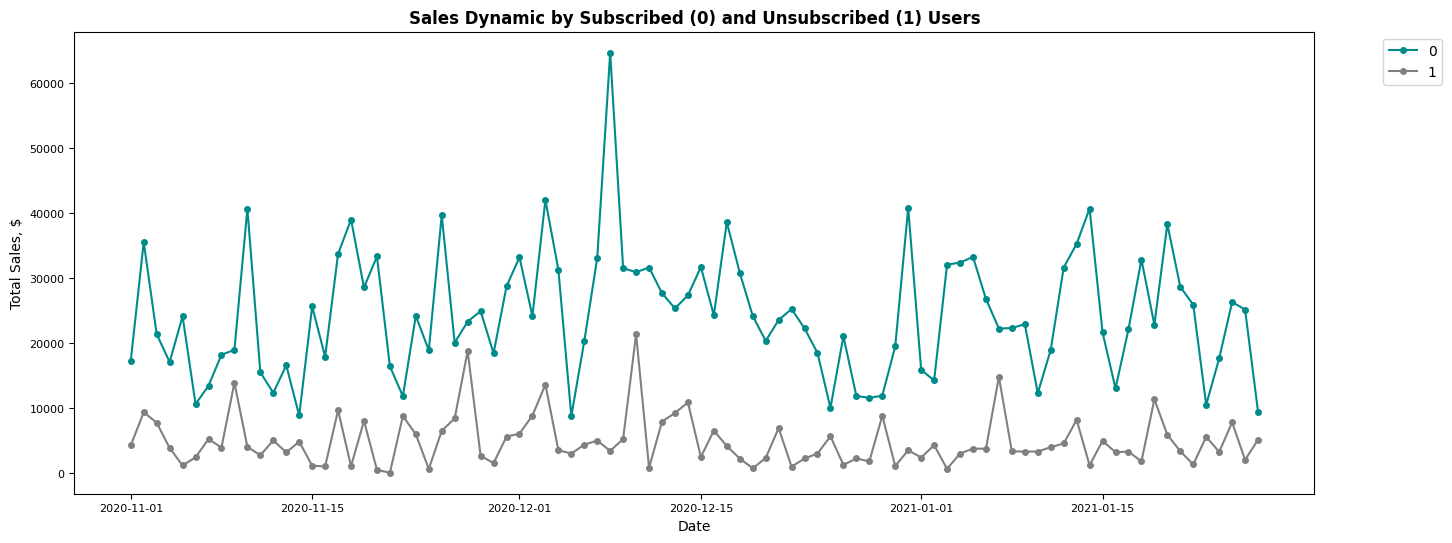

In [ ]:
users_sales = data.groupby(["date", "is_unsubscribed"])["price"].sum().reset_index()
colors = ['darkcyan', 'grey']

plt.figure(figsize=(16, 6))
for idx, category in enumerate(users_sales['is_unsubscribed'].unique()):
    category_data = users_sales[users_sales['is_unsubscribed'] == category]
    plt.plot(category_data['date'], category_data['price'], marker='o', markersize=4, label=category, color=colors[idx % len(colors)])
plt.title("Sales Dynamic by Subscribed (0) and Unsubscribed (1) Users", fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Total Sales, $")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.show()

In [ ]:
print("Total number of sessions and total sales for each date:\n")
sessions_sales = data.groupby("date").agg(total_session=("ga_session_id", "count"), total_sale=("price", "sum")).reset_index()
sessions_sales

Total number of sessions and total sales for each date:



,date,total_session,total_sale
0,2020-11-01,2576,244292.5
1,2020-11-02,3599,355506.8
2,2020-11-03,5173,498979.6
3,2020-11-04,4184,339187.1
4,2020-11-05,3743,391276.6
...,...,...,...
87,2021-01-27,4435,286340.7
88,2021-01-28,4112,0.0
89,2021-01-29,3700,0.0
90,2021-01-30,2845,0.0


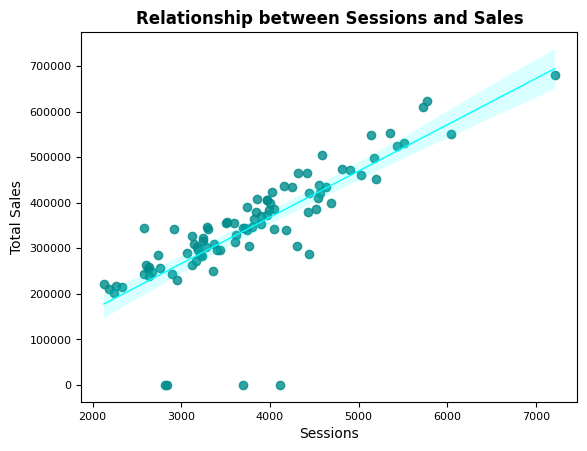

In [ ]:
sns.regplot(data=sessions_sales, x="total_session", y="total_sale", color="darkcyan", line_kws={"color": "cyan", "linewidth": 1})
plt.title("Relationship between Sessions and Sales", fontweight='bold')
plt.xlabel("Sessions")
plt.ylabel("Total Sales")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
print(f"The correlation between Total Sessions and Total Sales is {sessions_sales['total_session'].corr(sessions_sales['total_sale']).round(2)}.")
correlation, p_value = pearsonr(sessions_sales['total_session'], sessions_sales['total_sale'])

if p_value < 0.05:
    print(f"The correlation is statistically significant, with a p-value of {p_value}, which is less than 0.05.")
else:
    print("The correlation is not statistically significant.")

The correlation between Total Sessions and Total Sales is 0.79.
The correlation is statistically significant, with a p-value of 6.4835323120810494e-21, which is less than 0.05.


A correlation of 0.79 indicates a strong positive relationship between Total Sessions and Total Sales, meaning that more sessions lead to more sales.

In [ ]:
print(f"The company works on {data[data['continent'] != '(not set)']['continent'].nunique()} continents")

The company works on 5 continents


In [ ]:
print("The top 3 continents with the highest sales:")
data.groupby('continent')['price'].sum().nlargest(3)

The top 3 continents with the highest sales:


,price
continent,
Americas,17665280.0
Asia,7601298.3
Europe,5934624.2


In [ ]:
print("The top 3 continents with the largest number of orders:")
data.groupby('continent')['price'].count().nlargest(3)

The top 3 continents with the largest number of orders:


,price
continent,
Americas,18553
Asia,7950
Europe,6261


In [ ]:
print("Correlation between sales on continents:\n")
df = data.groupby(['date', 'continent'])['price'].sum().reset_index()
top_3_continents = df.groupby('continent')['price'].sum().nlargest(3).index
df_top = df[df['continent'].isin(top_3_continents)]
continents = df_top.pivot(index='date', columns='continent', values='price')
continents.corr()

Correlation between sales on continents:



continent,Americas,Asia,Europe
continent,,,
Americas,1.000000,0.792025,0.770586
Asia,0.792025,1.000000,0.768427
Europe,0.770586,0.768427,1.000000


In [ ]:
results = []

for col1 in continents.columns:
    for col2 in continents.columns:
        if col1 < col2:
            corr, p_value = pearsonr(continents[col1].dropna(), continents[col2].dropna())
            results.append((col1, col2, corr, p_value))

for col1, col2, corr, p_value in results:
    if p_value < 0.05:
        print(f"The correlation between {col1} and {col2} is statistically significant with a p-value of {p_value}, which is less than 0.05.")
    else:
        print(f"The correlation between {col1} and {col2} is not statistically significant.")

The correlation between Americas and Asia is statistically significant with a p-value of 5.4091893961972734e-21, which is less than 0.05.
The correlation between Americas and Europe is statistically significant with a p-value of 2.6714492240629807e-19, which is less than 0.05.
The correlation between Asia and Europe is statistically significant with a p-value of 3.864946009053125e-19, which is less than 0.05.


Given that the correlation is statistically significant, it suggests that there is a meaningful relationship between sales on the continents (which could be due to global trends, market interdependencies, economic, or even political events). They are not entirely independent, and business strategies should account for the interconnectedness of global markets.

In [ ]:
print(f"The company works with {data[data['country'] != '(not set)']['country'].nunique()} countries")

The company works with 107 countries


In [ ]:
print("The top 5 countries with the highest sales:")
data.groupby("country")["price"].sum().nlargest(5)

The top 5 countries with the highest sales:


,price
country,
United States,13943553.9
India,2809762.0
Canada,2437921.0
United Kingdom,938317.9
France,710692.8


In [ ]:
print("The top 5 countries with the largest number of orders:")
data.groupby("country")["price"].count().nlargest(5)

The top 5 countries with the largest number of orders:


,price
country,
United States,14673
India,3029
Canada,2560
United Kingdom,1029
France,678


In [ ]:
print(f"The company sells {data['product_category'].nunique()} product categories")

The company sells 14 product categories


In [ ]:
print("The company sold:")
data["product_category"].value_counts()

The company sold:


,count
product_category,
Bookcases & shelving units,7630
Chairs,5952
Sofas & armchairs,4301
Tables & desks,2941
Beds,2926
Cabinets & cupboards,2318
Outdoor furniture,2229
Children's furniture,1702
Chests of drawers & drawer units,1452


In [ ]:
print("The top 10 product categories by sales:")
data.groupby("product_category")["price"].sum().nlargest(10)

The top 10 product categories by sales:


,price
product_category,
Sofas & armchairs,8388254.5
Chairs,6147748.8
Beds,4919725.0
Bookcases & shelving units,3640818.1
Cabinets & cupboards,2336499.5
Outdoor furniture,2142222.2
Tables & desks,1790307.5
Chests of drawers & drawer units,906562.5
Bar furniture,735503.0


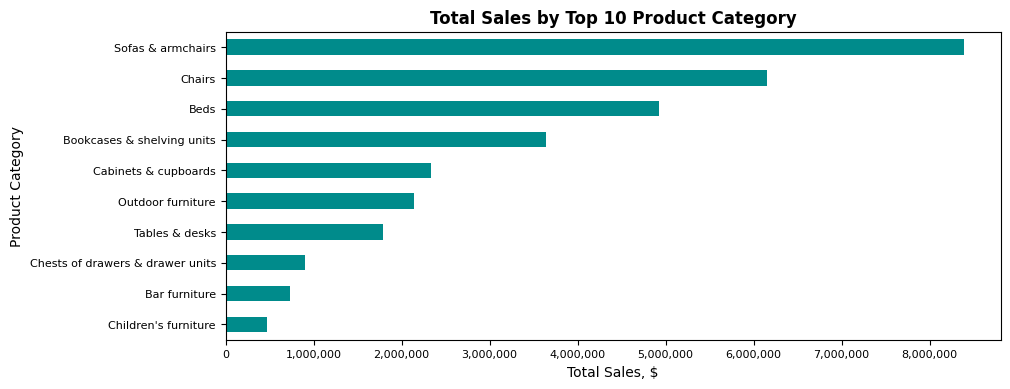

In [ ]:
plt.figure(figsize=(10, 4))
data.groupby("product_category")["price"].sum().nlargest(10).plot(kind="barh", color='darkcyan')
plt.title("Total Sales by Top 10 Product Category", fontweight='bold')
plt.xlabel("Total Sales, $")
plt.ylabel("Product Category")
plt.xticks(rotation=0, fontsize=8)
plt.yticks(fontsize=8)
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
print("The top 10 product categories by sales in the United States — the country with the highest sales:")
top_country = data.groupby('country')['price'].sum().idxmax()
top_10_categories = data[data['country'] == top_country].groupby('product_category')['price'].sum().nlargest(10)
top_10_categories

The top 10 product categories by sales in the United States — the country with the highest sales:


,price
product_category,
Sofas & armchairs,3707144.5
Chairs,2619773.8
Beds,2213058.0
Bookcases & shelving units,1567606.9
Cabinets & cupboards,994545.5
Outdoor furniture,929245.2
Tables & desks,777865.0
Chests of drawers & drawer units,382388.0
Bar furniture,330805.0


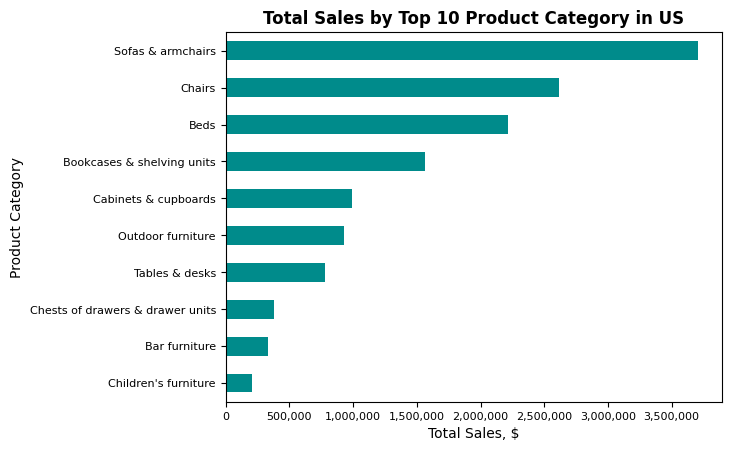

In [ ]:
top_10_categories.plot(kind="barh", color='darkcyan')
plt.title("Total Sales by Top 10 Product Category in US", fontweight='bold')
plt.xlabel("Total Sales, $")
plt.ylabel("Product Category")
plt.xticks(rotation=0, fontsize=8)
plt.yticks(fontsize=8)
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
plt.gca().invert_yaxis()
plt.show()

In [ ]:
print("The top 10 product categories by sales in the top 5 countries with the highest total sales:\n")
top_categories = data.groupby("product_category")["price"].sum().nlargest(10).index
top_countries = data.groupby("country")["price"].sum().nlargest(5).index
filtered_top = data[data["product_category"].isin(top_categories) & data["country"].isin(top_countries)]
pd.pivot_table(filtered_top, values="price", index="product_category", columns="country", aggfunc='sum')

The top 10 product categories by sales in the top 5 countries with the highest total sales:



country,Canada,France,India,United Kingdom,United States
product_category,,,,,
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5


In [ ]:
print("Correlation between sales of top 5 product categories:\n")
df = data.groupby(['date', 'product_category'])['price'].sum().reset_index()
top_5_categories = df.groupby('product_category')['price'].sum().nlargest(5).index
df_top = df[df['product_category'].isin(top_5_categories)]
category = df_top.pivot(index='date', columns='product_category', values='price')
category.corr()

Correlation between sales of top 5 product categories:



product_category,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Sofas & armchairs
product_category,,,,,
Beds,1.000000,0.592913,0.514609,0.554500,0.535378
Bookcases & shelving units,0.592913,1.000000,0.539428,0.637090,0.666194
Cabinets & cupboards,0.514609,0.539428,1.000000,0.572870,0.657563
Chairs,0.554500,0.637090,0.572870,1.000000,0.578248
Sofas & armchairs,0.535378,0.666194,0.657563,0.578248,1.000000


In [ ]:
results = []

for col1 in category.columns:
    for col2 in category.columns:
        if col1 < col2:
            corr, p_value = pearsonr(category[col1].dropna(), category[col2].dropna())
            results.append((col1, col2, corr, p_value))

for col1, col2, corr, p_value in results:
        if p_value < 0.05:
            print(f"The correlation between {col1} and {col2} is statistically significant with p-value less than 0.05.")
        else:
            print(f"The correlation between {col1} and {col2} is not statistically significant with p-value is more than 0.05.")

The correlation between Beds and Bookcases & shelving units is statistically significant with p-value less than 0.05.
The correlation between Beds and Cabinets & cupboards is statistically significant with p-value less than 0.05.
The correlation between Beds and Chairs is statistically significant with p-value less than 0.05.
The correlation between Beds and Sofas & armchairs is statistically significant with p-value less than 0.05.
The correlation between Bookcases & shelving units and Cabinets & cupboards is statistically significant with p-value less than 0.05.
The correlation between Bookcases & shelving units and Chairs is statistically significant with p-value less than 0.05.
The correlation between Bookcases & shelving units and Sofas & armchairs is statistically significant with p-value less than 0.05.
The correlation between Cabinets & cupboards and Chairs is statistically significant with p-value less than 0.05.
The correlation between Cabinets & cupboards and Sofas & armchai

A correlation range of 0.51 to 0.66 indicates a moderate to strong positive correlation between sales across product categories. This means that when sales increase in one category, sales in the other category tend to increase as well.   
Since the p-value is less than 0.05, the correlation is statistically significant, meaning that the relationship observed is not due to randomness, and there is a real underlying connection between the sales of these product categories.

In [ ]:
print("% of total sales by device:")
np.round(data.groupby("device")["price"].sum() / data["price"].sum() * 100, 2)

% of total sales by device:


,price
device,
desktop,59.00
mobile,38.73
tablet,2.26


In [ ]:
print("% of total sales by device model:")
np.round(data.groupby("mobile_model_name")["price"].sum() / data["price"].sum() *100, 2).sort_values(ascending=False)

% of total sales by device model:


,price
mobile_model_name,
Chrome,27.84
<Other>,20.44
Safari,20.30
iPhone,20.08
ChromeBook,5.73
Edge,2.18
iPad,1.40
Firefox,1.32
Pixel 4 XL,0.37


In [ ]:
print("% of total sales by traffic channel:")
np.round(data.groupby("channel")["price"].sum() / data["price"].sum() *100, 2).sort_values(ascending=False)

% of total sales by traffic channel:


,price
channel,
Organic Search,35.76
Paid Search,26.62
Direct,23.44
Social Search,7.92
Undefined,6.26


In [ ]:
print("Sales and number of orders by device type:")
data.groupby("device")["price"].agg(["sum", "count"]).sort_values(by="sum", ascending=False)

Sales and number of orders by device type:


,sum,count
device,,
desktop,18864039.0,19702
mobile,12384225.8,13113
tablet,723466.3,723


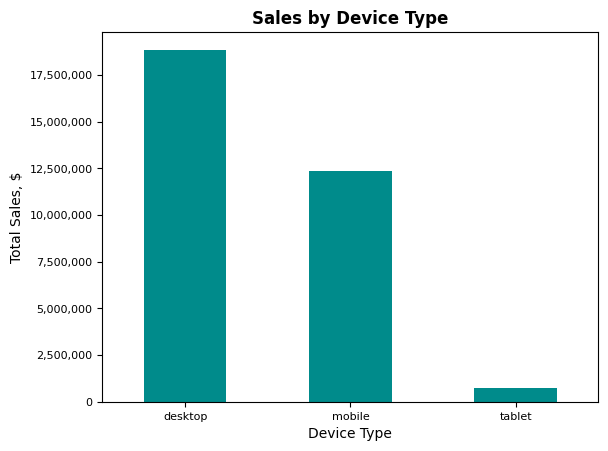

In [ ]:
data.groupby("device")["price"].sum().sort_values(ascending=False).plot(kind='bar', color='darkcyan')
plt.title("Sales by Device Type", fontweight='bold')
plt.xlabel("Device Type")
plt.ylabel("Total Sales, $")
plt.xticks(rotation=0, fontsize=8)
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
plt.show()

In [ ]:
print("Sales and number of orders by traffic channel:")
data.groupby("channel")["price"].agg(["sum", "count"]).sort_values(by="sum", ascending=False)

Sales and number of orders by traffic channel:


,sum,count
channel,,
Organic Search,11433151.6,11921
Paid Search,8511049.4,9042
Direct,7494923.4,7800
Social Search,2532105.7,2716
Undefined,2000501.0,2059


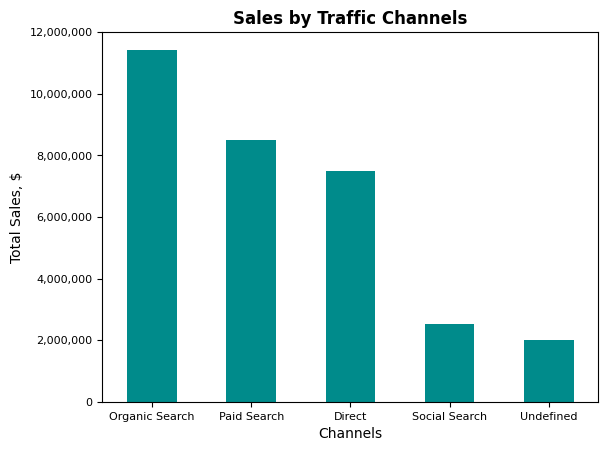

In [ ]:
data.groupby("channel")["price"].sum().sort_values(ascending=False).plot(kind='bar', color='darkcyan')
plt.title("Sales by Traffic Channels", fontweight='bold')
plt.xlabel("Channels")
plt.ylabel("Total Sales, $")
plt.xticks(rotation=0, fontsize=8)
plt.yticks(fontsize=8)
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
plt.show()

In [ ]:
print("The total number of orders by traffic channel for each device type:\n")
pd.pivot_table(data, values="ga_session_id", index="device", columns="channel", aggfunc='count')

The total number of orders by traffic channel for each device type:



channel,Direct,Organic Search,Paid Search,Social Search,Undefined
device,,,,,
desktop,47825,72622,55167,16288,12527
mobile,31745,49014,37034,10988,8486
tablet,1812,2789,2140,638,470


# Sales Dynamics Analysis

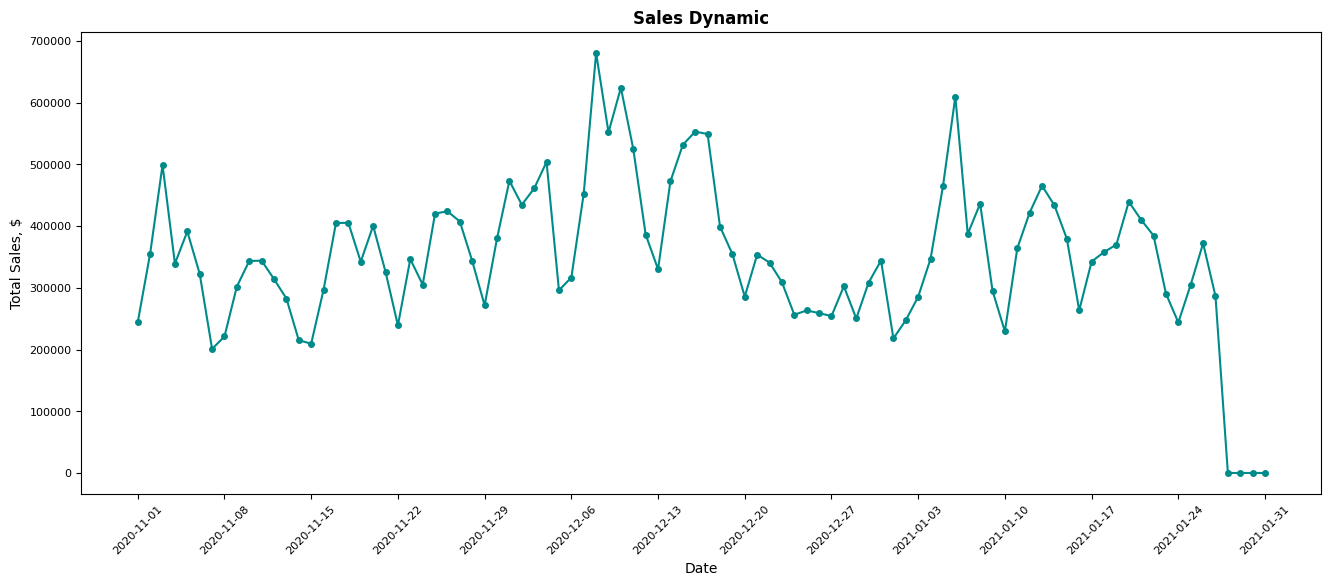

In [ ]:
sales = data.groupby("date")["price"].sum().reset_index()
plt.figure(figsize=(16, 6))
plt.plot(sales["date"], sales["price"], marker='o', markersize=4, color='darkcyan')
unique_dates = sales['date'].unique()
selected_dates = unique_dates[::7]
plt.xticks(selected_dates, rotation=45, fontsize=8)
plt.title("Sales Dynamic", fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Total Sales, $")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [ ]:
sales_by_continents = data.groupby("continent")["price"].sum().sort_values(ascending=False)
sales_by_continents

,price
continent,
Americas,17665280.0
Asia,7601298.3
Europe,5934624.2
Oceania,365230.2
Africa,331231.0
(not set),74067.4


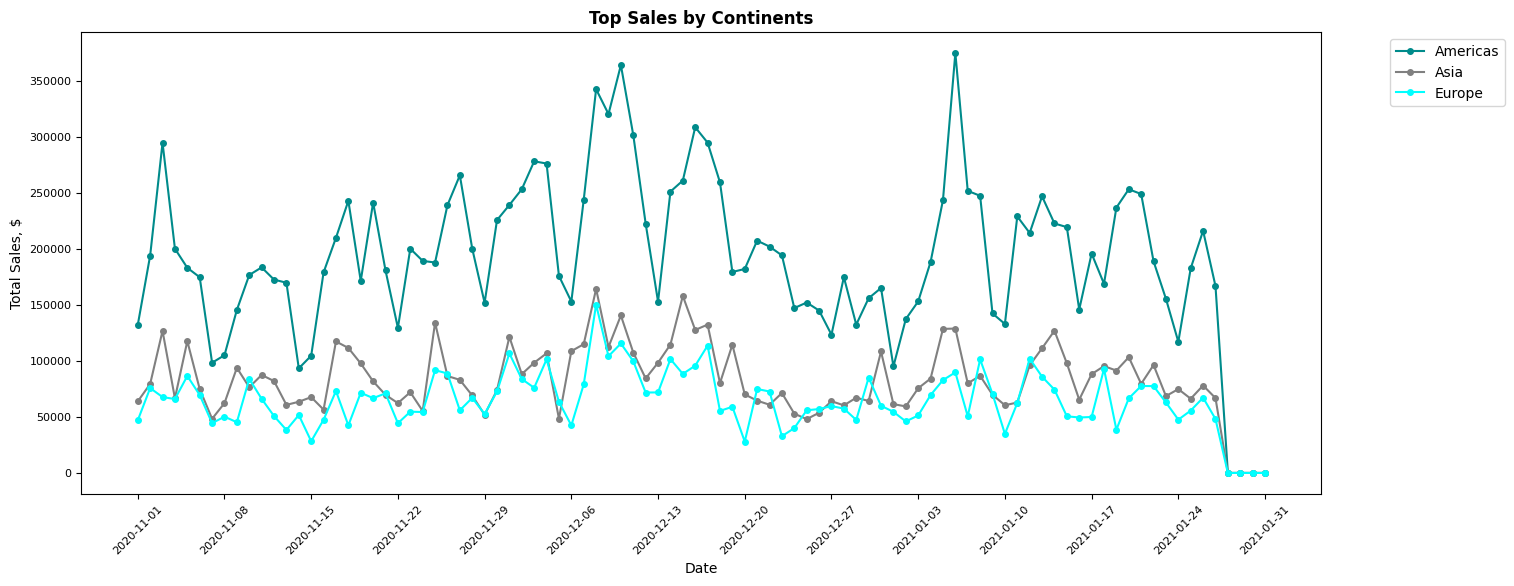

In [ ]:
continent_sales = data[data["continent"].isin(["Americas", "Europe", "Asia"])].groupby(["date", "continent"])["price"].sum().reset_index()
colors = ['darkcyan', 'grey', 'cyan']

plt.figure(figsize=(16, 6))
for idx, category in enumerate(continent_sales['continent'].unique()):
    category_data = continent_sales[continent_sales['continent'] == category]
    plt.plot(category_data['date'], category_data['price'], marker='o', markersize=4, label=category, color=colors[idx % len(colors)])

unique_dates = continent_sales['date'].unique()
selected_dates = unique_dates[::7]
plt.xticks(selected_dates, rotation=45, fontsize=8)

plt.title("Top Sales by Continents", fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Total Sales, $")
plt.yticks(fontsize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.show()

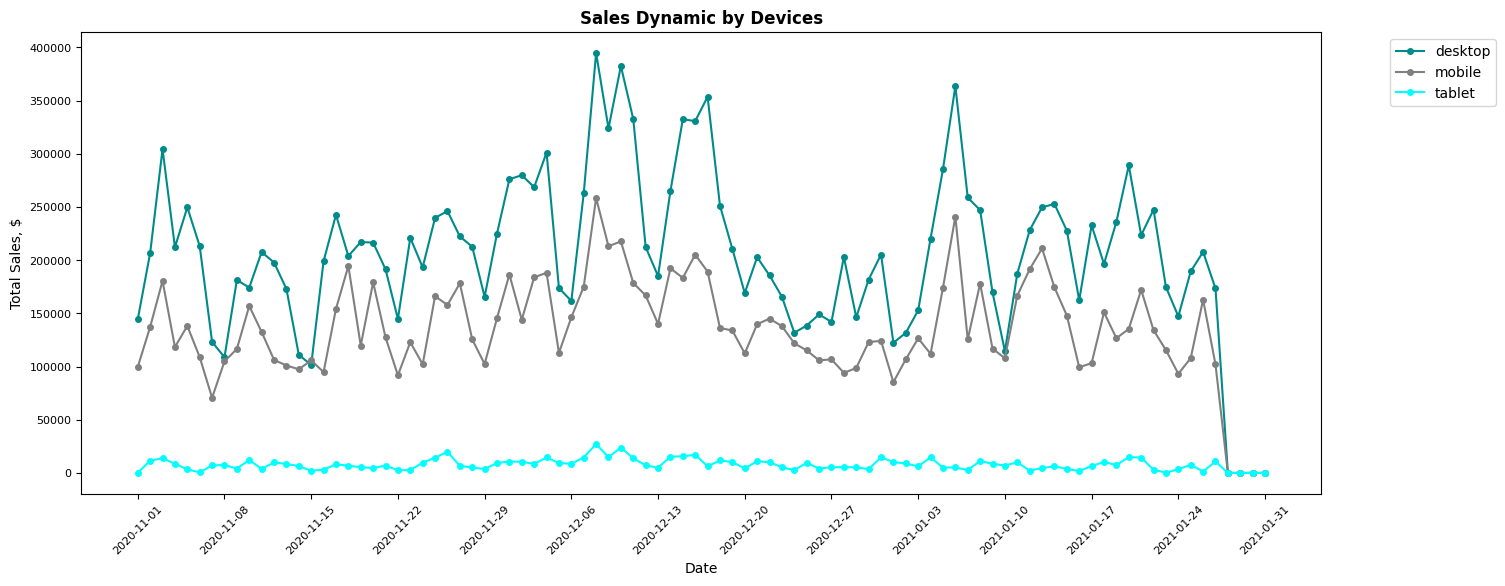

In [ ]:
device_sales = data.groupby(["date", "device"])["price"].sum().reset_index()
colors = ['darkcyan', 'grey', 'cyan']

plt.figure(figsize=(16, 6))
for idx, category in enumerate(device_sales['device'].unique()):
    category_data = device_sales[device_sales['device'] == category]
    plt.plot(category_data['date'], category_data['price'], marker='o', markersize=4, label=category, color=colors[idx % len(colors)])
unique_dates = device_sales['date'].unique()
selected_dates = unique_dates[::7]
plt.xticks(selected_dates, rotation=45, fontsize=8)
plt.title("Sales Dynamic by Devices", fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Total Sales, $")
plt.yticks(fontsize=8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.show()

Sales dynamics, both overall and by continent/device, show spikes in the second half of December, likely due to pre-holiday purchases, and in early January, which may be related to the holiday weekend and discounts. The increase in sales on certain dates at the end of November is likely related to Black Friday and Cyber Monday discounts, along with Thanksgiving preparations in the US and Canada.  
The spike on November 1st may mark the transition from Halloween sales to early promotions for the holiday shopping season. There may have been discounts on leftover Halloween items.

Let's examine the dynamics for the US, the largest market for our company:

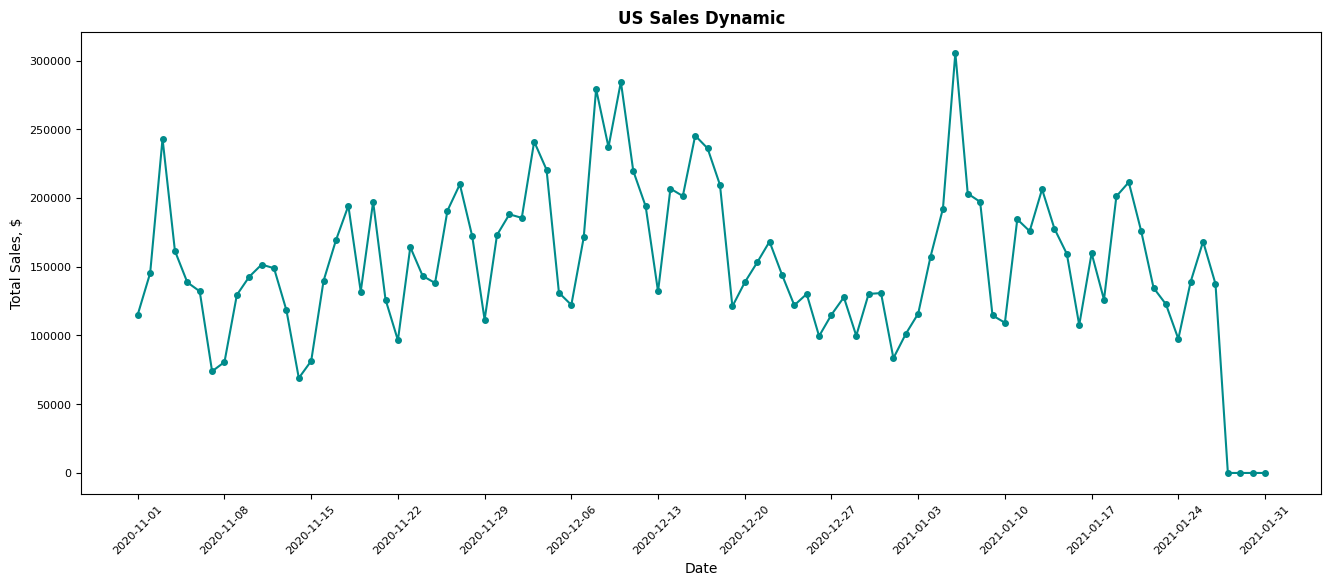

In [ ]:
us = data[data["country"] == "United States"].groupby("date")["price"].sum().reset_index()

plt.figure(figsize=(16, 6))
plt.plot(us["date"], us["price"], marker='o', markersize=4, color='darkcyan')
unique_dates = us['date'].unique()
selected_dates = unique_dates[::7]
plt.xticks(selected_dates, rotation=45, fontsize=8)
plt.title("US Sales Dynamic", fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Total Sales, $")
plt.yticks(fontsize=8)
plt.show()

As can be seen from the graph, all the spikes align with those on the general graph, which confirms that the United States has the greatest impact on increasing sales during certain periods.

# Additional:

Tableau Dashboard: https://public.tableau.com/views/SalesSessionsAnalysis/SalesSessionsAnalysis?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link